# Lab 09-3: ResNet for ImageNet Challenge (ILSVRC)
## Exercise: Image Classification

Load Libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


Prepare Datasets

In [2]:
dataset = 'cifar10'

if dataset == 'cifar10':
    # Load the original CIFAR10 dataset
    # CIFAR10 dataset contains 50000 training images and 10000 test images of 32x32x3 pixels
    # Each image contains a small object such as bird, truck, etc...
    (ds_train, ds_test, ds_val), ds_info = tfds.load('cifar10', split=['train[:80%]', 'test', 'train[80%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
elif dataset == 'imagenette':
    # Imagenette is a subset of 10 easily classified classes from Imagenet 
    # (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).
    (ds_train, ds_test, ds_val), ds_info = tfds.load('imagenette/320px-v2', split=['train', 'validation[:50%]', 'validation[50%:]'],
                                                 batch_size=None, shuffle_files=True, as_supervised=True,
                                                 with_info=True)
else:
    print('Dataset Error')

print(ds_info.features)
print(ds_info.splits)
print(ds_info.splits['train'].num_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteRNHY6L/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteRNHY6L/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
{'test': <tfds.core.SplitInfo num_examples=10000>, 'train': <tfds.core.SplitInfo num_examples=50000>}
50000


In [3]:
n_channels = ds_info.features['image'].shape[-1]

if dataset == 'imagenette':
    classes = ['tench', 'English springer', 'cassette player', 'chain saw', 
               'church', 'French horn', 'garbage truck', 'gas pump', 
               'golf ball', 'parachute']
else:
    classes = ds_info.features['label'].names
n_classes = ds_info.features['label'].num_classes

n_train = len(ds_train)
n_test = len(ds_test)
n_val = len(ds_val)

print(n_train,n_test,n_val)

40000 10000 10000


Show a Sample Data

Image demension: (32, 32, 3) , label: 2


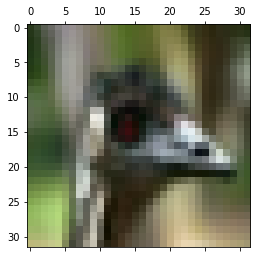

The picture is bird


In [4]:
idx = np.random.randint(n_train-1)

for element in ds_train.skip(idx).take(1):
    image, label = element
    
print('Image demension:', image.shape, ', label:',label.numpy())

dimage = tf.reshape(image, image.shape)
plt.matshow(dimage)
plt.show()
print('The picture is', classes[label])

Build Input Data Pipelines

In [5]:
def tfds_4_NET(image, label):

    image = tf.image.resize((image / 255), [224,224], method='bilinear')
    label = tf.one_hot(label, n_classes) 

    return image, label

In [6]:
n_batch = 64

dataset = ds_train.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

valiset = ds_val.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
valiset = valiset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

testset = ds_test.map(tfds_4_NET, num_parallel_calls=tf.data.AUTOTUNE)
testset = testset.shuffle(buffer_size = 256).batch(batch_size=n_batch)

## Build the Model for ResNet with Keras Model Subclassing

Define Premitive Blocks for ResNet: Identity Block and Projection Block

In [7]:
class IdenBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(IdenBlock, self).__init__(**kwargs)
        flt1, flt2, flt3 = filters

        ### START CODE HERE ###

        # in_channels, intermediate_channels, identity_downsample=None, stride=1
        self.conv1 = tf.keras.layers.Conv2D(flt1, 1, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(flt2, 3, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(flt3, 1, padding='same')

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.relu1 = tf.keras.layers.Activation('relu')
        self.relu2 = tf.keras.layers.Activation('relu')
        self.relu3 = tf.keras.layers.Activation('relu')

        self.add3 = tf.keras.layers.Add()

        ### END CODE HERE ###

    def call(self, x):
        ### START CODE HERE ###

        x_shortcut = x   # make shortcut
        x = self.relu1(self.bn1(self.conv1(x)))            # first layer   
        x = self.relu2(self.bn2(self.conv2(x)))            # second layer  
        x = self.bn3(self.conv3(x))            # third layer   
        x = self.add3([x, x_shortcut])            # add layer     
        x = self.relu3(x)            # final activation

        ### END CODE HERE ###
        return x

class ProjBlock(tf.keras.layers.Layer):
    def __init__(self, filters, st, **kwargs):
        super(ProjBlock, self).__init__(**kwargs)
        flt1, flt2, flt3 = filters

        ### START CODE HERE ###

        self.conv0 = tf.keras.layers.Conv2D(flt3, 1, strides=(st,st))
        self.conv1 = tf.keras.layers.Conv2D(flt1, 1, strides=(st,st))
        self.conv2 = tf.keras.layers.Conv2D(flt2, 3, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(flt3, 1, padding='same')

        self.bn0 = tf.keras.layers.BatchNormalization()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.relu1 = tf.keras.layers.Activation('relu')
        self.relu2 = tf.keras.layers.Activation('relu')
        self.relu3 = tf.keras.layers.Activation('relu')

        self.add3 = tf.keras.layers.Add()

        ### END CODE HERE ###

    def call(self, x):
        ### START CODE HERE ###

        x_shortcut = self.bn0(self.conv0(x))   # make shortcut
        x = self.relu1(self.bn1(self.conv1(x)))            # first layer   
        x = self.relu2(self.bn2(self.conv2(x)))            # second layer  
        x = self.bn3(self.conv3(x))            # third layer   
        x = self.add3([x, x_shortcut])            # add layer     
        x = self.relu3(x)            # final activation

        ### END CODE HERE ###
        return x

Build the Entire Model

In [22]:
# model
class ResNet50(tf.keras.Model):

    def __init__(self, num_classes=10, **kwargs):
        super(ResNet50, self).__init__()

        # input_size = (224,224,n_channels)
        ### START CODE HERE ###

        self.cnv1_cv = tf.keras.layers.Conv2D(64, 7, strides=(2,2), padding='same')
        self.cnv1_bn = tf.keras.layers.BatchNormalization()
        self.cnv1_ac = tf.keras.layers.Activation('relu')
        self.cnv1_pl = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')

        self.cnv2_b1 = ProjBlock((64,64,256), st=1)         # projection layer
        self.cnv2_b2 = IdenBlock((64,64,256))         # identity layer
        self.cnv2_b3 = IdenBlock((64,64,256))         # identity layer

        self.cnv3_b1 = ProjBlock((128,128,512), st=2)         # projection layer
        self.cnv3_b2 = IdenBlock((128,128,512))         # identity layer
        self.cnv3_b3 = IdenBlock((128,128,512))
        self.cnv3_b4 = IdenBlock((128,128,512))

        self.cnv4_b1 = ProjBlock((256,256,1024), st=2)
        self.cnv4_b2 = IdenBlock((256,256,1024))
        self.cnv4_b3 = IdenBlock((256,256,1024))
        self.cnv4_b4 = IdenBlock((256,256,1024))
        self.cnv4_b5 = IdenBlock((256,256,1024))
        self.cnv4_b6 = IdenBlock((256,256,1024))

        self.cnv5_b1 = ProjBlock((512,512,2048), st=2)
        self.cnv5_b2 = IdenBlock((512,512,2048))
        self.cnv5_b3 = IdenBlock((512,512,2048))
        self.cnv5_p1 = tf.keras.layers.AveragePooling2D(pool_size=(2,2), padding='same')         # pooling layer

        self.lyr6_f1 = tf.keras.layers.Flatten()
        self.lyr6_fc = tf.keras.layers.Dense(num_classes, activation='softmax')

        ### END CODE HERE ###

    def call(self, inputs):
        x = self.cnv1_pl(self.cnv1_ac(self.cnv1_bn(self.cnv1_cv(inputs))))
        x = self.cnv2_b3(self.cnv2_b2(self.cnv2_b1(x)))
        x = self.cnv3_b4(self.cnv3_b3(self.cnv3_b2(self.cnv3_b1(x))))
        x = self.cnv4_b6(self.cnv4_b5(self.cnv4_b4(self.cnv4_b3(self.cnv4_b2(self.cnv4_b1(x))))))
        x = self.cnv5_p1(self.cnv5_b3(self.cnv5_b2(self.cnv5_b1(x))))
        x = self.lyr6_fc( self.lyr6_f1(x))
        return x

### Training The Model

In [23]:
ResNet = ResNet50()                                            # get model object
ResNet.build(input_shape=(None,224,224,n_channels))            # build model network
ResNet.call(tf.keras.layers.Input(shape=(224,224,n_channels))) # single run to identify model shapes
ResNet.summary(show_trainable=True)                            # report model summary

# compile
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
ResNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

Model: "res_net50_7"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_319 (Conv2D)         (None, 112, 112, 64)      9472      Y          
                                                                            
 batch_normalization_319 (Ba  (None, 112, 112, 64)     256       Y          
 tchNormalization)                                                          
                                                                            
 activation_295 (Activation)  (None, 112, 112, 64)     0         Y          
                                                                            
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         Y          
 2D)                                                                        
                                                                            
 proj_block_24 (ProjBlock)   (None, 56, 56, 256)       

In [24]:
n_epochs = 5

results = ResNet.fit(dataset, epochs=n_epochs, batch_size=n_batch,
                     validation_data=valiset, validation_batch_size=n_batch,
                     verbose=1)

Epoch 1/5
625/625 [==============================] - 449s 702ms/step - loss: 2.5006 - acc: 0.3392 - val_loss: 9.7657 - val_acc: 0.2935
Epoch 2/5
625/625 [==============================] - 432s 692ms/step - loss: 1.3534 - acc: 0.5140 - val_loss: 1.2367 - val_acc: 0.5629
Epoch 3/5
625/625 [==============================] - 432s 691ms/step - loss: 1.0858 - acc: 0.6140 - val_loss: 1.1328 - val_acc: 0.6287
Epoch 4/5
625/625 [==============================] - 434s 694ms/step - loss: 0.9270 - acc: 0.6793 - val_loss: 1.1591 - val_acc: 0.6471
Epoch 5/5
625/625 [==============================] - 434s 694ms/step - loss: 0.8056 - acc: 0.7203 - val_loss: 1.0804 - val_acc: 0.6824


Plot Convergence Graph

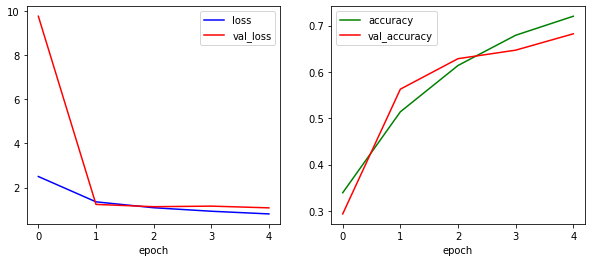

In [25]:
# plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(results.history['loss'], 'b-', label='loss')
plt.plot(results.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(results.history['acc'], 'g-', label='accuracy')
plt.plot(results.history['val_acc'], 'r-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

Evaluate Model Performance

In [26]:
ResNet.evaluate(testset)

157/157 [==============================] - 35s 218ms/step - loss: 1.0985 - acc: 0.6736


[1.0985088348388672, 0.6736000180244446]

### Test Model with a Random Sample


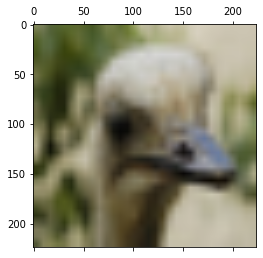

My prediction is bird
Actual image is  bird


In [27]:
idx = np.random.randint(n_test-1)

for element in ds_test.skip(idx).take(1):
    img, lbl = element
    X_test, y_test = tfds_4_NET(img, lbl)

X_test = tf.expand_dims(X_test, axis=0)

dimage = np.array(X_test[0])
plt.matshow(dimage)
plt.show()

outt_4 = ResNet.predict(X_test)
p_pred = np.argmax(outt_4, axis=-1)

print('My prediction is ' + classes[p_pred[0]])
print('Actual image is  ' + classes[tf.argmax(y_test, -1)])